# Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())

from settings import *

# Ensure that the visuals are displayed within the Jupyter notebook
%matplotlib inline

# Set the aesthetics for the seaborn plots
sns.set(style="whitegrid")  

# Load the dataset
df = pd.read_csv(REVIEW_FILE_PATH)

c:\Users\cedric.baron\source\repos\Fine-Food-Review-Analysis


In [1]:
from azureml.core.model import InferenceConfig
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

ML_WORKSPACE = get_workspace()
environment = Environment('my-sklearn-environment')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'pandas',
])


# High level overview

In [2]:
# First 5 rows of the dataset:
print(df.head(), '\n')

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [3]:
# Data types and missing values:
print(df.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None 



In [4]:
# Basic Statistical Details:
print(df.describe(), '\n')

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09   



In [5]:
# Count of unique values in each column:
print(df.nunique(), '\n')

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64 



# Checking the helpfulness of reviews

In [6]:
# Number of users who found the review helpful
df['HelpfulnessNumerator'].describe()

count    568454.000000
mean          1.743817
std           7.636513
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

In [7]:
# Number of users who indicated whether they found the review helpful or not
df['HelpfulnessDenominator'].describe()

count    568454.00000
mean          2.22881
std           8.28974
min           0.00000
25%           0.00000
50%           1.00000
75%           2.00000
max         923.00000
Name: HelpfulnessDenominator, dtype: float64

In [8]:
# Calculate the helpfulness ratio
df['HelpfulnessRatio'] = np.where(df['HelpfulnessDenominator'] > 0, 
                                  df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], 
                                  np.nan)

In [9]:
df['HelpfulnessRatio'].describe()

count    298402.000000
mean          0.776975
std           0.346321
min           0.000000
25%           0.600000
50%           1.000000
75%           1.000000
max           3.000000
Name: HelpfulnessRatio, dtype: float64

In [10]:
# since some values are above 1 which is impossible we remove them
df['HelpfulnessRatio'] = df['HelpfulnessRatio'].apply(lambda x: 1.0 if x > 1.0 else x)

In [11]:
nan_count = df['HelpfulnessRatio'].isna().sum()
nan_count

270052

# Distributions visualizations

Text(0.5, 0.98, 'Histograms of Numerical Features (Filtered)')

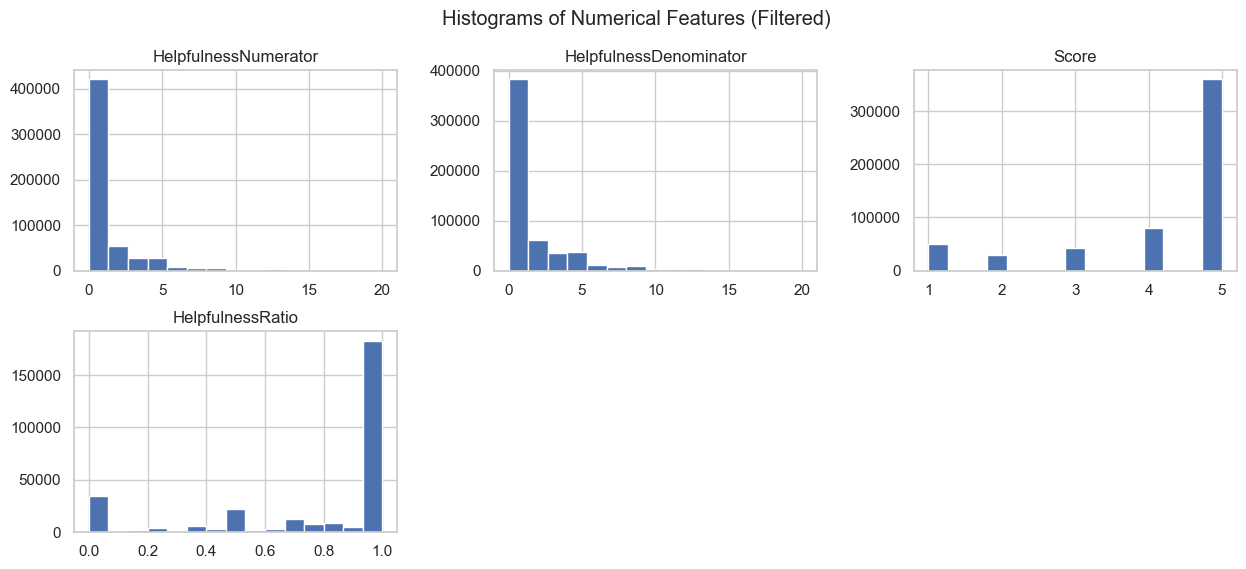

In [12]:
# Select numerical features, excluding 'Id' and 'Time'
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
num_features = [feature for feature in num_features if feature not in ['Id', 'Time']]

# Create a new DataFrame with the numerical features of interest
df_num = df[num_features]

# Filter the DataFrame to include only values between 0 and 5 for 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
df_num_filtered = df_num[(df_num['HelpfulnessNumerator'].between(0, 20)) & (df_num['HelpfulnessDenominator'].between(0, 20))]

# Histograms for filtered numerical features
df_num_filtered.hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.suptitle('Histograms of Numerical Features (Filtered)')


C:\Users\cedric.baron\AppData\Local\Temp\ipykernel_14612\2131128099.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(df, values='Id',


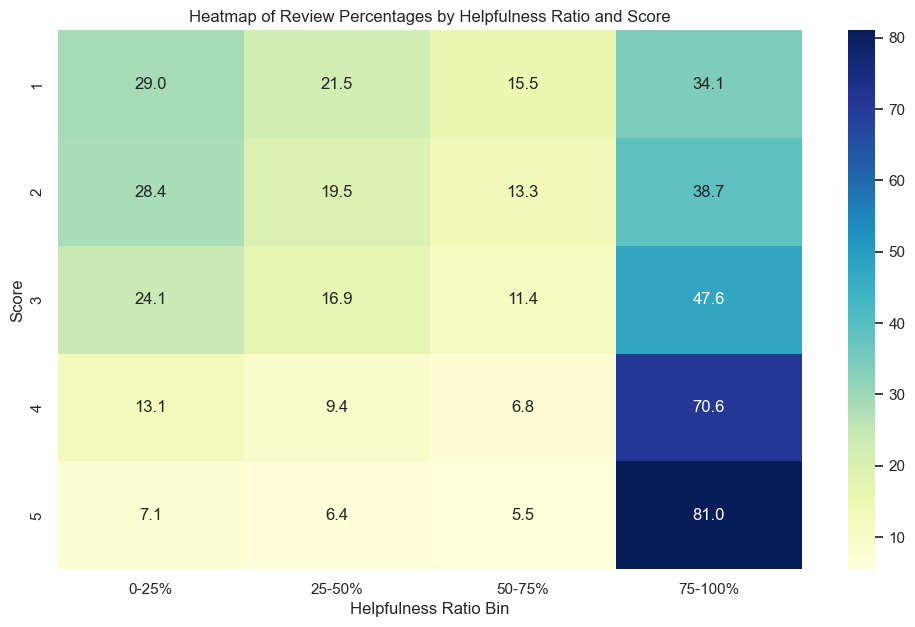

In [13]:

# Define bins for HelpfulnessRatio
bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ['0-25%', '25-50%', '50-75%', '75-100%']
df['HelpfulnessRatioBin'] = pd.cut(df['HelpfulnessRatio'], bins=bins, labels=labels, include_lowest=True)

# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(df, values='Id', 
                              index=['Score'], 
                              columns='HelpfulnessRatioBin', 
                              aggfunc='count', fill_value=0)

# Convert counts to percentages of the row totals
heatmap_data_percentage = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# Plot the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data_percentage, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Review Percentages by Helpfulness Ratio and Score')
plt.xlabel('Helpfulness Ratio Bin')
plt.ylabel('Score')
plt.show()

In [17]:
# Filter the DataFrame for reviews with a score of 0 and helpfulness ratio below 0.1
filtered_reviews = df[(df['Score'] < 4) & (df['HelpfulnessRatio'] > 0.1)]

# Select a random review (or more, adjust n as needed) from the filtered DataFrame
random_reviews = filtered_reviews.sample(n=1)

# Print the random review(s)
for index, row in random_reviews.iterrows():
    print(f"Review ID: {row['Id']}")
    print(f"Product ID: {row['ProductId']}")
    print(f"User ID: {row['UserId']}")
    print(f"Profile Name: {row['ProfileName']}")
    print(f"Helpfulness Numerator: {row['HelpfulnessNumerator']}")
    print(f"Helpfulness Denominator: {row['HelpfulnessDenominator']}")
    print(f"Score: {row['Score']}")
    print(f"Time: {row['Time']}")
    print(f"Summary: {row['Summary']}")
    print(f"Text: {row['Text']}\n")


Review ID: 144451
Product ID: B000G18NS4
User ID: A2GC2ZB9ALT0Y6
Profile Name: K. Desai
Helpfulness Numerator: 2
Helpfulness Denominator: 3
Score: 3
Time: 1241136000
Summary: Make sure you taste these locally before ordering a 12 pack!
Text: I love Amy's foods but the taste of these beans are not my favorite. They taste way different than other refried black bean companies. I think its that they are sweeter? Not sure but make sure you like the flavor before ordering. I just assumed I would and now I am forcing 12 cans of beans down my throat that I don't really care for.<br /><br />Nothing against Amy's or these beans. Just preference.



Conclusion: Nothing special about reviews with low HelpfulnessRatio. Does not look super usable